# Resizer using Hardware

This reference design illustrates how to run a resizer IP using the **Hardware Accelerator** using Jupyter Notebooks and Python.

<img src="./images/resizenb.png" width="800" height="650"/>

In this example, we will use the **Bilinear** interpolation.

> The resize IP transforms the source image to the size of the destination image. Different types of interpolation techniques can be used in resize function,
namely: Nearest-neighbor, Bilinear, and Area interpolation. The type of interpolation can be passed as a parameter to the Python API.    
> Reference: https://xilinx.github.io/Vitis_Libraries/vision/2022.1/api-reference.html#resolution-conversion

## Contents    
  

* [Image Resizing using Hardware](#Image-Resizing-using-Hardware)
* [Import libraries](#Import-libraries)
* [Download the Resize IP bitstream](#Download-the-Resize-IP-bitstream)
* [Create an Image object using PIL in SW](#Create-an-Image-object-using-PIL-in-SW)
* [Display the image to be resized](#Display-the-image-to-be-resized)
* [Resizing](#Resizing)
* [Display resized image](#Display-resized-image)
* [References](#References)   

## Image Resizing using Hardware


<img src="./images/resize_bd.png" width="650"/>

## Import libraries

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pynq import Xlnk, Overlay, allocate

## Download the Resize IP bitstream

After the bitstream has been downloaded, the device will be 
populated with the resize IP and a few other components. 
The resize IP is configured to use bilinear interpolation.

In [2]:
resize_design = Overlay("resizer.xclbin")

We can check the function signature of the resizer.

In [3]:
resizer = resize_design.resize_accel_1
resizer.signature

<Signature (img_inp: 'ap_uint<128>*', img_out: 'ap_uint<128>*', rows_in: 'int', cols_in: 'int', rows_out: 'int', cols_out: 'int')>

## Create an Image object using PIL in SW
We will load image from the hard disk and create a PIL Image object.

Image By Aboubakrhadnine - <span class="int-own-work" lang="en">Own work</span>, <a href="https://creativecommons.org/licenses/by-sa/4.0" title="Creative Commons Attribution-Share Alike 4.0">CC BY-SA 4.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=79587474">Link</a>.

In [4]:
image_path = "images/sahara.jpg"
original_image = Image.open(image_path)

<img src="images/hd2dram.png" width="650"/>

## Display the image to be resized

Let's also check the original image size. It may take a while to render a 
large picture. For better visual effect, we double the size of the canvas.
The following code only changes the display size, not the picture itself:

```python
canvas = plt.gcf()
size = canvas.get_size_inches()
canvas.set_size_inches(size*2)
```

Image size: 3840x2160 pixels.


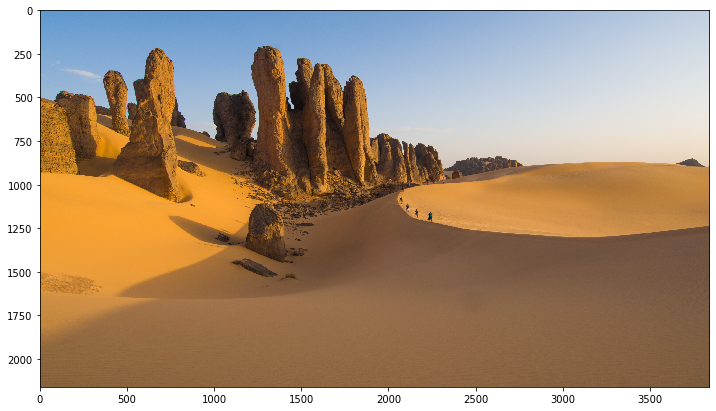

In [5]:
canvas = plt.gcf()
size = canvas.get_size_inches()
canvas.set_size_inches(size*2)

old_width, old_height = original_image.size
print("Image size: {}x{} pixels.".format(old_width, old_height))
_ = plt.imshow(original_image)

## Resizing
 
We can set resize dimensions.
1. Downscale factor: 2.
2. Size of input image is 3840x2160.
3. Size of output image is 1920x1080.

In [6]:
resize_factor = 2
new_width = int(old_width/resize_factor)
new_height = int(old_height/resize_factor)

We now allocate memory to process data using the device.
Data is provided as contiguous memory blocks.
The size of the buffer depends on the size of the input or output data.
The image dimensions extracted from the read image are used to allocate contiguous memory blocks.   
We will call `pynq.allocate()` to perform the allocation.
The accelerator is attached to DDR0/bank0/HBM0 and DDR1/bank1/HBM0 (depending on the platform) for input and output, 
respectively; hence we need to specify `target` properly.

In [7]:
if 'bank0' in resize_design.mem_dict:
    mem_port0 = resize_design.bank0
    mem_port1 = resize_design.bank1
elif 'DDR0' in resize_design.mem_dict:
    mem_port0 = resize_design.DDR0
    mem_port0 = resize_design.DDR1
elif 'HBM0' in resize_design.mem_dict:
    mem_port0 = resize_design.HBM0
    mem_port0 = resize_design.HBM1
else:
    print("Please specify correct mem_port0 and mem_port1.")

In [8]:
in_buffer = allocate((old_height, old_width, 3), np.uint8, 
                     target=mem_port0)
out_buffer = allocate((new_height, new_width, 3), np.uint8, 
                      target=mem_port1)

Documentation snippet for `pynq.buffer.allocate()`:

```python
"""Allocate a PYNQ buffer

The target determines where the buffer gets allocated.

* If Nonen then the currently active device is used
* If a device is specified then the main memory is used

"""
```

Note that the original image has to be copied into the contiguous memory array (deep copy).

<img src="./images/local2shared.png" width="650"/>

In [9]:
in_buffer[:] = np.array(original_image)

We can now run the resizer IP.
We will push the data from input buffer through the pipeline to the output buffer.

<img src="./images/resize_accel.png" width="650"/>

In [10]:
in_buffer.sync_to_device()
resizer.call(in_buffer, out_buffer, 
             old_height, old_width, new_height, new_width)
out_buffer.sync_from_device()
resized_image = Image.fromarray(out_buffer)

## Display resized image

Image size: 1920x1080 pixels.


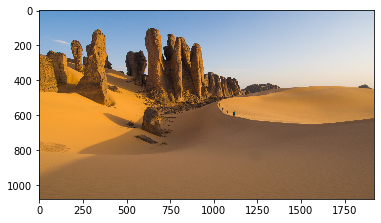

In [11]:
print("Image size: {}x{} pixels.".format(new_width, new_height))
_ = plt.imshow(resized_image)

We can time the resize operation.

In [12]:
%%timeit
in_buffer.flush()
resizer.call(in_buffer, out_buffer, 
             old_height, old_width, new_height, new_width)
out_buffer.invalidate()
resized_image = Image.fromarray(out_buffer)

39.9 ms ± 194 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Finally, we have to deallocate the buffers and 
free the FPGA context using `Overlay.free`.

In [13]:
del in_buffer
del out_buffer
resize_design.free()

[Contents](#Contents)

# References

https://pillow.readthedocs.io/en/3.1.x/index.html   
https://github.com/Xilinx/PYNQ/blob/master/docs/source/python_environment.ipynb   
https://github.com/Xilinx/PYNQ/blob/master/docs/source/jupyter_notebooks.ipynb   
https://github.com/Xilinx/PYNQ/blob/master/docs/source/jupyter_notebooks_advanced_features.ipynb   